## Loading in Data

In [1]:
import types
import pandas as pd
import numpy as np
from botocore.client import Config
import ibm_boto3
from sklearn import preprocessing
import matplotlib.pyplot as plt
import requests # library to handle requests
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import json
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

In [2]:
# The code was removed by Watson Studio for sharing.

,GEO_ID,NAME,S0101_C01_001E,S0101_C01_001M,S0101_C01_002E,S0101_C01_002M,S0101_C01_003E,S0101_C01_003M,S0101_C01_004E,S0101_C01_004M,...,S0101_C03_032E,S0101_C03_032M,S0101_C03_033E,S0101_C03_033M,S0101_C03_034E,S0101_C03_034M,S0101_C03_035E,S0101_C03_035M,S0101_C03_036E,S0101_C03_036M
0,id,Geographic Area Name,Total!!Estimate!!Total population,Total!!Margin of Error!!Total population,Total!!Estimate!!AGE!!Under 5 years,Total!!Margin of Error!!AGE!!Under 5 years,Total!!Estimate!!AGE!!5 to 9 years,Total!!Margin of Error!!AGE!!5 to 9 years,Total!!Estimate!!AGE!!10 to 14 years,Total!!Margin of Error!!AGE!!10 to 14 years,...,Female!!Estimate!!SUMMARY INDICATORS!!Age depe...,Female!!Margin of Error!!SUMMARY INDICATORS!!A...,Female!!Estimate!!SUMMARY INDICATORS!!Age depe...,Female!!Margin of Error!!SUMMARY INDICATORS!!A...,Female!!Estimate!!SUMMARY INDICATORS!!Age depe...,Female!!Margin of Error!!SUMMARY INDICATORS!!A...,Female!!Estimate!!PERCENT IMPUTED!!Sex,Female!!Margin of Error!!PERCENT IMPUTED!!Sex,Female!!Estimate!!PERCENT IMPUTED!!Age,Female!!Margin of Error!!PERCENT IMPUTED!!Age
1,0500000US17083,"Jersey County, Illinois",22932,*****,6.1,0.4,5.8,0.7,7.4,0.7,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
2,0500000US17085,"Jo Daviess County, Illinois",22728,*****,5.3,0.1,5.6,0.7,5.9,0.7,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
3,0500000US17087,"Johnson County, Illinois",12710,*****,4.8,*****,4.3,0.8,6.8,0.8,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
4,0500000US17089,"Kane County, Illinois",502628,*****,8.2,0.1,8.3,0.2,8.0,0.2,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)


In [3]:
# The code was removed by Watson Studio for sharing.

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,6,10,14,16,18,20,22,24,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,52,54,56,58,60,62,64,66,68,70,72,74,76,78,80,82,84,86,88,90,92,94,96,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,124,126,128,130,132,134,136,138,140,142,144,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,274,276,278,280,282,284,286,288,290,291,292,293,294,295,296,297,298,299,300,301,303,305,307,309,311,313,314,315,316,317,318,319,320,321,322,323

,GEO_ID,NAME,S0101_C01_001E,S0101_C01_001M,S0101_C02_001E,S0101_C02_001M,S0101_C03_001E,S0101_C03_001M,S0101_C04_001E,S0101_C04_001M,...,S0101_C02_038E,S0101_C02_038M,S0101_C03_038E,S0101_C03_038M,S0101_C04_038E,S0101_C04_038M,S0101_C05_038E,S0101_C05_038M,S0101_C06_038E,S0101_C06_038M
0,id,Geographic Area Name,Estimate!!Total!!Total population,Margin of Error!!Total MOE!!Total population,Estimate!!Percent!!Total population,Margin of Error!!Percent MOE!!Total population,Estimate!!Male!!Total population,Margin of Error!!Male MOE!!Total population,Estimate!!Percent Male!!Total population,Margin of Error!!Percent Male MOE!!Total popul...,...,Estimate!!Percent!!PERCENT ALLOCATED!!Age,Margin of Error!!Percent MOE!!PERCENT ALLOCATE...,Estimate!!Male!!PERCENT ALLOCATED!!Age,Margin of Error!!Male MOE!!PERCENT ALLOCATED!!Age,Estimate!!Percent Male!!PERCENT ALLOCATED!!Age,Margin of Error!!Percent Male MOE!!PERCENT ALL...,Estimate!!Female!!PERCENT ALLOCATED!!Age,Margin of Error!!Female MOE!!PERCENT ALLOCATED...,Estimate!!Percent Female!!PERCENT ALLOCATED!!Age,Margin of Error!!Percent Female MOE!!PERCENT A...
1,0500000US01001,"Autauga County, Alabama",55200,*****,(X),(X),26874,147,(X),(X),...,1.3,(X),(X),(X),(X),(X),(X),(X),(X),(X)
2,0500000US01003,"Baldwin County, Alabama",208107,*****,(X),(X),101188,242,(X),(X),...,1.8,(X),(X),(X),(X),(X),(X),(X),(X),(X)
3,0500000US01005,"Barbour County, Alabama",25782,*****,(X),(X),13697,71,(X),(X),...,0.9,(X),(X),(X),(X),(X),(X),(X),(X),(X)
4,0500000US01007,"Bibb County, Alabama",22527,*****,(X),(X),12152,180,(X),(X),...,8.2,(X),(X),(X),(X),(X),(X),(X),(X),(X)


In [4]:
# The code was removed by Watson Studio for sharing.

,Year,State,County ID,State / County Name,All Ages SAIPE Poverty Universe,All Ages in Poverty Count,All Ages in Poverty Count LB 90%,All Ages in Poverty Count UB 90%,90% Confidence Interval (All Ages in Poverty Count),All Ages in Poverty Percent,...,Under Age 5 in Poverty Count UB 90%,90% Confidence Interval (Under Age 5 in Poverty Count),Under Age 5 in Poverty Percent,Under Age 5 in Poverty Percent LB 90%,Under Age 5 in Poverty Percent UB 90%,90% Confidence Interval (Under Age 5 in Poverty Percent),Median Household Income in Dollars,Median Household Income in Dollars LB 90%,Median Household Income in Dollars UB 90%,90% Confidence Interval (Median Household Income in Dollars)
0,2010,0,0,United States,"301,535,021","46,215,956","45,975,650","46,456,262","45,975,650 to 46,456,262",15.3,...,"5,012,276","4,910,772 to 5,012,276",25.0,24.8,25.2,24.8 to 25.2,"$50,046","$49,982","$50,110","$49,982 to $50,110"
1,2010,1,1000,Alabama,"4,667,040","883,078","867,106","899,050","867,106 to 899,050",18.9,...,"98,250","89,540 to 98,250",31.3,29.8,32.8,29.8 to 32.8,"$40,538","$40,081","$40,995","$40,081 to $40,995"
2,2010,1,1001,Autauga County (AL),"54,145","6,459","5,075","7,843","5,075 to 7,843",11.9,...,NaN,NaN,NaN,NaN,NaN,NaN,"$53,049","$49,486","$56,612","$49,486 to $56,612"
3,2010,1,1003,Baldwin County (AL),"180,560","24,056","20,333","27,779","20,333 to 27,779",13.3,...,NaN,NaN,NaN,NaN,NaN,NaN,"$47,618","$45,169","$50,067","$45,169 to $50,067"
4,2010,1,1005,Barbour County (AL),"24,146","6,098","4,749","7,447","4,749 to 7,447",25.3,...,NaN,NaN,NaN,NaN,NaN,NaN,"$33,074","$30,589","$35,559","$30,589 to $35,559"


In [5]:
# The code was removed by Watson Studio for sharing.

,Year,State,County ID,State / County Name,All Ages SAIPE Poverty Universe,All Ages in Poverty Count,All Ages in Poverty Count LB 90%,All Ages in Poverty Count UB 90%,90% Confidence Interval (All Ages in Poverty Count),All Ages in Poverty Percent,...,Under Age 5 in Poverty Count UB 90%,90% Confidence Interval (Under Age 5 in Poverty Count),Under Age 5 in Poverty Percent,Under Age 5 in Poverty Percent LB 90%,Under Age 5 in Poverty Percent UB 90%,90% Confidence Interval (Under Age 5 in Poverty Percent),Median Household Income in Dollars,Median Household Income in Dollars LB 90%,Median Household Income in Dollars UB 90%,90% Confidence Interval (Median Household Income in Dollars)
0,2018,51,51107,Loudoun County (VA),"404,541","14,700","12,380","17,020","12,380 to 17,020",3.6,...,NaN,NaN,NaN,NaN,NaN,NaN,"$140,382","$135,638","$145,126","$135,638 to $145,126"
1,2018,51,51610,Falls Church city (VA),"14,746",535,401,669,401 to 669,3.6,...,NaN,NaN,NaN,NaN,NaN,NaN,"$137,551","$124,738","$150,364","$124,738 to $150,364"
2,2018,6,6085,Santa Clara County (CA),"1,911,186","139,074","127,269","150,879","127,269 to 150,879",7.3,...,NaN,NaN,NaN,NaN,NaN,NaN,"$125,933","$123,281","$128,585","$123,281 to $128,585"
3,2018,35,35028,Los Alamos County (NM),"18,972",733,570,896,570 to 896,3.9,...,NaN,NaN,NaN,NaN,NaN,NaN,"$124,947","$114,051","$135,843","$114,051 to $135,843"
4,2018,6,6041,Marin County (CA),"253,013","16,742","13,811","19,673","13,811 to 19,673",6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,"$122,933","$116,812","$129,054","$116,812 to $129,054"


In [6]:
#Removing that top row of the ACS dataframes that are just description filler, not data

ACS_2018 = ACS_2018.iloc[1:]
ACS_2010 = ACS_2010.iloc[1:]

## Data Cleaning and Organizing

In [7]:
#renaming columns in dfs

ACS_2018.rename(columns={'S0101_C01_001E': 'Total Population'}, inplace = True)
ACS_2018.rename(columns={'S0101_C03_001E': 'Total Male Population'}, inplace = True)
ACS_2018.rename(columns={'S0101_C05_001E': 'Total Female Population'}, inplace = True)

ACS_2010.rename(columns={'S0101_C01_001E': 'Total Population'}, inplace = True)
ACS_2010.rename(columns={'S0101_C02_001E': 'Total Male Population'}, inplace = True)
ACS_2010.rename(columns={'S0101_C03_001E': 'Total Female Population'}, inplace = True)


In [8]:
#renaming columns in dfs

Poverty_2010.rename(columns={'All Ages in Poverty Percent': 'Poverty Percent'}, inplace = True)
Poverty_2010.rename(columns={'Median Household Income in Dollars': 'MHI'}, inplace = True)

Poverty_2018.rename(columns={'All Ages in Poverty Percent': 'Poverty Percent'}, inplace = True)
Poverty_2018.rename(columns={'Median Household Income in Dollars': 'MHI'}, inplace = True)

In [9]:
#looking at two counties that have changed in the 10 year period: Shannon County SD, and Wade Hampton County AK
ACS_2010[ACS_2010['NAME'] == 'Shannon County, South Dakota']

,GEO_ID,NAME,Total Population,S0101_C01_001M,S0101_C01_002E,S0101_C01_002M,S0101_C01_003E,S0101_C01_003M,S0101_C01_004E,S0101_C01_004M,...,S0101_C03_032E,S0101_C03_032M,S0101_C03_033E,S0101_C03_033M,S0101_C03_034E,S0101_C03_034M,S0101_C03_035E,S0101_C03_035M,S0101_C03_036E,S0101_C03_036M
2482,0500000US46113,"Shannon County, South Dakota",13437,*****,11.6,0.5,9.7,1.4,11.4,1.5,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)


In [10]:
ACS_2018[ACS_2018['NAME'] == 'Oglala Lakota County, South Dakota'] #Shannon County was renamed Oglala Lakota County, and the GEO_ID has also changed

,GEO_ID,NAME,Total Population,S0101_C01_001M,S0101_C02_001E,S0101_C02_001M,Total Male Population,S0101_C03_001M,S0101_C04_001E,S0101_C04_001M,...,S0101_C02_038E,S0101_C02_038M,S0101_C03_038E,S0101_C03_038M,S0101_C04_038E,S0101_C04_038M,S0101_C05_038E,S0101_C05_038M,S0101_C06_038E,S0101_C06_038M
2413,0500000US46102,"Oglala Lakota County, South Dakota",14335,*****,(X),(X),6989,114,(X),(X),...,3.1,(X),(X),(X),(X),(X),(X),(X),(X),(X)


In [11]:
ACS_2010[ACS_2010['NAME'] == 'Wade Hampton Census Area, Alaska']

,GEO_ID,NAME,Total Population,S0101_C01_001M,S0101_C01_002E,S0101_C01_002M,S0101_C01_003E,S0101_C01_003M,S0101_C01_004E,S0101_C01_004M,...,S0101_C03_032E,S0101_C03_032M,S0101_C03_033E,S0101_C03_033M,S0101_C03_034E,S0101_C03_034M,S0101_C03_035E,S0101_C03_035M,S0101_C03_036E,S0101_C03_036M
156,0500000US02270,"Wade Hampton Census Area, Alaska",7398,*****,11.6,0.1,10.6,0.6,12.0,0.6,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)


In [12]:
ACS_2018[ACS_2018['NAME'] == 'Kusilvak Census Area, Alaska'] #Wade Hamptom (2010) has been replaced with Kusilvak Census Area, also of a different geoid

#I kept the 2018 names, so we don't need to worry about changing the whole 2010 info. So we just need to change the GEO_ID 2010 version to the 2018 GEO_ID for these individual counties.

,GEO_ID,NAME,Total Population,S0101_C01_001M,S0101_C02_001E,S0101_C02_001M,Total Male Population,S0101_C03_001M,S0101_C04_001E,S0101_C04_001M,...,S0101_C02_038E,S0101_C02_038M,S0101_C03_038E,S0101_C03_038M,S0101_C04_038E,S0101_C04_038M,S0101_C05_038E,S0101_C05_038M,S0101_C06_038E,S0101_C06_038M
82,0500000US02158,"Kusilvak Census Area, Alaska",8198,*****,(X),(X),4388,93,(X),(X),...,1.0,(X),(X),(X),(X),(X),(X),(X),(X),(X)


In [13]:
Poverty_2010[Poverty_2010['State / County Name'] == 'Shannon County (SD)']

,Year,State,County ID,State / County Name,All Ages SAIPE Poverty Universe,All Ages in Poverty Count,All Ages in Poverty Count LB 90%,All Ages in Poverty Count UB 90%,90% Confidence Interval (All Ages in Poverty Count),Poverty Percent,...,Under Age 5 in Poverty Count UB 90%,90% Confidence Interval (Under Age 5 in Poverty Count),Under Age 5 in Poverty Percent,Under Age 5 in Poverty Percent LB 90%,Under Age 5 in Poverty Percent UB 90%,90% Confidence Interval (Under Age 5 in Poverty Percent),MHI,Median Household Income in Dollars LB 90%,Median Household Income in Dollars UB 90%,90% Confidence Interval (Median Household Income in Dollars)
2460,2010,46,46113,Shannon County (SD),"13,604","6,428","5,317","7,539","5,317 to 7,539",47.3,...,NaN,NaN,NaN,NaN,NaN,NaN,"$27,307","$24,775","$29,839","$24,775 to $29,839"


In [14]:
Poverty_2018[Poverty_2018['State / County Name'] == 'Oglala Lakota County (SD)'] #ok, so 46102 is the county ID we need to switch the 2010 data to

,Year,State,County ID,State / County Name,All Ages SAIPE Poverty Universe,All Ages in Poverty Count,All Ages in Poverty Count LB 90%,All Ages in Poverty Count UB 90%,90% Confidence Interval (All Ages in Poverty Count),Poverty Percent,...,Under Age 5 in Poverty Count UB 90%,90% Confidence Interval (Under Age 5 in Poverty Count),Under Age 5 in Poverty Percent,Under Age 5 in Poverty Percent LB 90%,Under Age 5 in Poverty Percent UB 90%,90% Confidence Interval (Under Age 5 in Poverty Percent),MHI,Median Household Income in Dollars LB 90%,Median Household Income in Dollars UB 90%,90% Confidence Interval (Median Household Income in Dollars)
3145,2018,46,46102,Oglala Lakota County (SD),"14,235","7,688","6,746","8,630","6,746 to 8,630",54.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"$31,662","$28,148","$35,176","$28,148 to $35,176"


In [15]:
Poverty_2010.loc[Poverty_2010['State / County Name'] == 'Wade Hampton Census Area (AK)']

,Year,State,County ID,State / County Name,All Ages SAIPE Poverty Universe,All Ages in Poverty Count,All Ages in Poverty Count LB 90%,All Ages in Poverty Count UB 90%,90% Confidence Interval (All Ages in Poverty Count),Poverty Percent,...,Under Age 5 in Poverty Count UB 90%,90% Confidence Interval (Under Age 5 in Poverty Count),Under Age 5 in Poverty Percent,Under Age 5 in Poverty Percent LB 90%,Under Age 5 in Poverty Percent UB 90%,90% Confidence Interval (Under Age 5 in Poverty Percent),MHI,Median Household Income in Dollars LB 90%,Median Household Income in Dollars UB 90%,90% Confidence Interval (Median Household Income in Dollars)
95,2010,2,2270,Wade Hampton Census Area (AK),"7,427","2,530","2,011","3,049","2,011 to 3,049",34.1,...,NaN,NaN,NaN,NaN,NaN,NaN,"$30,883","$28,181","$33,585","$28,181 to $33,585"


In [16]:
Poverty_2018[Poverty_2018['State / County Name'] == 'Kusilvak Census Area (AK)'] #so we want the 2010 county id to be 2158

,Year,State,County ID,State / County Name,All Ages SAIPE Poverty Universe,All Ages in Poverty Count,All Ages in Poverty Count LB 90%,All Ages in Poverty Count UB 90%,90% Confidence Interval (All Ages in Poverty Count),Poverty Percent,...,Under Age 5 in Poverty Count UB 90%,90% Confidence Interval (Under Age 5 in Poverty Count),Under Age 5 in Poverty Percent,Under Age 5 in Poverty Percent LB 90%,Under Age 5 in Poverty Percent UB 90%,90% Confidence Interval (Under Age 5 in Poverty Percent),MHI,Median Household Income in Dollars LB 90%,Median Household Income in Dollars UB 90%,90% Confidence Interval (Median Household Income in Dollars)
3124,2018,2,2158,Kusilvak Census Area (AK),"8,279","2,905","2,444","3,366","2,444 to 3,366",35.1,...,NaN,NaN,NaN,NaN,NaN,NaN,"$32,728","$30,532","$34,924","$30,532 to $34,924"


In [17]:
#Pre-emptively converting those two counties 2010 GEOIDs to their future, 2018 ones. This way we can keep track of them as the same county in future datasets, even as their names change

#ACS Dataset

#first, changing Shannon County ID to its future County ID in 2018
ACS_2010.loc[ACS_2010['GEO_ID'] == '0500000US46113', 'GEO_ID'] = '0500000US46102'

#now, changing Wade Hampton Census Area County ID to its future County ID in 2018
ACS_2010.loc[ACS_2010['GEO_ID'] == '0500000US02270', 'GEO_ID']  = '0500000US02158'

In [18]:
#Poverty Dataset

#first, changing Shannon County ID to its future County ID in 2018
Poverty_2010.loc[Poverty_2010['State / County Name'] == 'Shannon County (SD)', 'County ID'] = 46102

#now, changing Wade Hampton Census Area County ID to its future County ID in 2018
Poverty_2010.loc[Poverty_2010['State / County Name'] == 'Wade Hampton Census Area (AK)', 'County ID'] = 2158

In [19]:
#ACS 2018 and 2010: Need to segment out their GEO Ids

ACS_2018['County ID'] = ACS_2018['GEO_ID'].str.slice(9)
ACS_2010['County ID'] = ACS_2010['GEO_ID'].str.slice(9)

In [20]:
#Taking only the counties for the Poverty datasets

Poverty_2010 = Poverty_2010[Poverty_2010['State / County Name'].str.contains('\(',case= True)]
Poverty_2018 = Poverty_2018[Poverty_2018['State / County Name'].str.contains('\(',case= True)]

In [21]:
Poverty_2018.head()

,Year,State,County ID,State / County Name,All Ages SAIPE Poverty Universe,All Ages in Poverty Count,All Ages in Poverty Count LB 90%,All Ages in Poverty Count UB 90%,90% Confidence Interval (All Ages in Poverty Count),Poverty Percent,...,Under Age 5 in Poverty Count UB 90%,90% Confidence Interval (Under Age 5 in Poverty Count),Under Age 5 in Poverty Percent,Under Age 5 in Poverty Percent LB 90%,Under Age 5 in Poverty Percent UB 90%,90% Confidence Interval (Under Age 5 in Poverty Percent),MHI,Median Household Income in Dollars LB 90%,Median Household Income in Dollars UB 90%,90% Confidence Interval (Median Household Income in Dollars)
0,2018,51,51107,Loudoun County (VA),"404,541","14,700","12,380","17,020","12,380 to 17,020",3.6,...,NaN,NaN,NaN,NaN,NaN,NaN,"$140,382","$135,638","$145,126","$135,638 to $145,126"
1,2018,51,51610,Falls Church city (VA),"14,746",535,401,669,401 to 669,3.6,...,NaN,NaN,NaN,NaN,NaN,NaN,"$137,551","$124,738","$150,364","$124,738 to $150,364"
2,2018,6,6085,Santa Clara County (CA),"1,911,186","139,074","127,269","150,879","127,269 to 150,879",7.3,...,NaN,NaN,NaN,NaN,NaN,NaN,"$125,933","$123,281","$128,585","$123,281 to $128,585"
3,2018,35,35028,Los Alamos County (NM),"18,972",733,570,896,570 to 896,3.9,...,NaN,NaN,NaN,NaN,NaN,NaN,"$124,947","$114,051","$135,843","$114,051 to $135,843"
4,2018,6,6041,Marin County (CA),"253,013","16,742","13,811","19,673","13,811 to 19,673",6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,"$122,933","$116,812","$129,054","$116,812 to $129,054"


In [22]:
#lets create a dataset with just the features we want
#we need to remember which data is from which year though
#check the meta-data files for a better look at which columsn correspond to what variable

#For ACS Features
Features_A2010 = ['GEO_ID', 'County ID', 'NAME', 'Total Population', 'Total Male Population', 'Total Female Population']
Features_A2018 = ['GEO_ID', 'County ID', 'NAME', 'Total Population', 'Total Male Population', 'Total Female Population']


#For Poverty Features
Features_P2010 = ['County ID', 'State / County Name', 'Poverty Percent', 'MHI']
Features_P2018 = ['County ID', 'State / County Name', 'Poverty Percent', 'MHI']

Ok, I just want to check that those feature pulls are working alright

In [23]:
ACS_2018[Features_A2018].head() #cool, the Features_A2018 works

,GEO_ID,County ID,NAME,Total Population,Total Male Population,Total Female Population
1,0500000US01001,01001,"Autauga County, Alabama",55200,26874,28326
2,0500000US01003,01003,"Baldwin County, Alabama",208107,101188,106919
3,0500000US01005,01005,"Barbour County, Alabama",25782,13697,12085
4,0500000US01007,01007,"Bibb County, Alabama",22527,12152,10375
5,0500000US01009,01009,"Blount County, Alabama",57645,28434,29211


In [24]:
ACS_2010[Features_A2010].head() #cool, the Features_A2010 works

,GEO_ID,County ID,NAME,Total Population,Total Male Population,Total Female Population
1,0500000US17083,17083,"Jersey County, Illinois",22932,11221,11711
2,0500000US17085,17085,"Jo Daviess County, Illinois",22728,11431,11297
3,0500000US17087,17087,"Johnson County, Illinois",12710,7146,5564
4,0500000US17089,17089,"Kane County, Illinois",502628,251087,251541
5,0500000US17091,17091,"Kankakee County, Illinois",112100,55042,57058


In [25]:
Poverty_2010[Features_P2010].head() #cool, the Features_P2010 works

,County ID,State / County Name,Poverty Percent,MHI
2,1001,Autauga County (AL),11.9,"$53,049"
3,1003,Baldwin County (AL),13.3,"$47,618"
4,1005,Barbour County (AL),25.3,"$33,074"
5,1007,Bibb County (AL),20.9,"$35,472"
6,1009,Blount County (AL),16.5,"$42,906"


In [26]:
Poverty_2018[Features_P2018].head() #cool, the Features_P2018 works

,County ID,State / County Name,Poverty Percent,MHI
0,51107,Loudoun County (VA),3.6,"$140,382"
1,51610,Falls Church city (VA),3.6,"$137,551"
2,6085,Santa Clara County (CA),7.3,"$125,933"
3,35028,Los Alamos County (NM),3.9,"$124,947"
4,6041,Marin County (CA),6.6,"$122,933"


Great, so I can fully segment these into new dataframes now

In [27]:
dfP_2010 = Poverty_2010[Features_P2010]
dfP_2018 = Poverty_2018[Features_P2018]

dfA_2010 = ACS_2010[Features_A2010]
dfA_2018 = ACS_2018[Features_A2018]

In [28]:
##Checking the datasets

#dfP_2010.head()
dfP_2018.head()
#dfA_2010.head()
#dfA_2018.head()

,County ID,State / County Name,Poverty Percent,MHI
0,51107,Loudoun County (VA),3.6,"$140,382"
1,51610,Falls Church city (VA),3.6,"$137,551"
2,6085,Santa Clara County (CA),7.3,"$125,933"
3,35028,Los Alamos County (NM),3.9,"$124,947"
4,6041,Marin County (CA),6.6,"$122,933"


In [29]:
#Splitting the 'County, State' format of the ACS datasets into two separate columns: County and State

splitCol = dfA_2018['NAME'].str.split(",", expand = True)
dfA_2018['County'] = splitCol[0]
dfA_2018['State'] = splitCol[1]
dfA_2018.drop(columns = ['NAME'], inplace = True)

splitCol = dfA_2010['NAME'].str.split(",", expand = True)
dfA_2010['County'] = splitCol[0]
dfA_2010['State'] = splitCol[1]
dfA_2010.drop(columns = ['NAME'], inplace = True)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [30]:
##Checking the datasets

#dfP_2010.head()
#dfP_2018.head()
dfA_2010.head()
#dfA_2018.head()

,GEO_ID,County ID,Total Population,Total Male Population,Total Female Population,County,State
1,0500000US17083,17083,22932,11221,11711,Jersey County,Illinois
2,0500000US17085,17085,22728,11431,11297,Jo Daviess County,Illinois
3,0500000US17087,17087,12710,7146,5564,Johnson County,Illinois
4,0500000US17089,17089,502628,251087,251541,Kane County,Illinois
5,0500000US17091,17091,112100,55042,57058,Kankakee County,Illinois


In [31]:
#merge the Poverty to Poverty sets first, ACS to ACS. Both via the geo codes

#poverty 2010 to 2018 merge
dfP = pd.merge(left = dfP_2010, right = dfP_2018, on = 'County ID', suffixes = (' 2010', ' 2018'))

#ACS 2010 to 2018 merge
dfA = pd.merge(left = dfA_2010, right = dfA_2018, on = 'GEO_ID', suffixes = (' 2010', ' 2018'))

In [32]:
dfP.head()

,County ID,State / County Name 2010,Poverty Percent 2010,MHI 2010,State / County Name 2018,Poverty Percent 2018,MHI 2018
0,1001,Autauga County (AL),11.9,"$53,049",Autauga County (AL),13.8,"$59,338"
1,1003,Baldwin County (AL),13.3,"$47,618",Baldwin County (AL),9.8,"$57,588"
2,1005,Barbour County (AL),25.3,"$33,074",Barbour County (AL),30.9,"$34,382"
3,1007,Bibb County (AL),20.9,"$35,472",Bibb County (AL),21.8,"$46,064"
4,1009,Blount County (AL),16.5,"$42,906",Blount County (AL),13.2,"$50,412"


In [33]:
dfA.head()

,GEO_ID,County ID 2010,Total Population 2010,Total Male Population 2010,Total Female Population 2010,County 2010,State 2010,County ID 2018,Total Population 2018,Total Male Population 2018,Total Female Population 2018,County 2018,State 2018
0,0500000US17083,17083,22932,11221,11711,Jersey County,Illinois,17083,22069,10841,11228,Jersey County,Illinois
1,0500000US17085,17085,22728,11431,11297,Jo Daviess County,Illinois,17085,21834,10956,10878,Jo Daviess County,Illinois
2,0500000US17087,17087,12710,7146,5564,Johnson County,Illinois,17087,12602,7015,5587,Johnson County,Illinois
3,0500000US17089,17089,502628,251087,251541,Kane County,Illinois,17089,530839,264211,266628,Kane County,Illinois
4,0500000US17091,17091,112100,55042,57058,Kankakee County,Illinois,17091,111061,54615,56446,Kankakee County,Illinois


### Dealing with each dataset now, creating the change variables

**dfA** 
> needs change metrics between: Total population, Male population, Female population

In [34]:
dfA['Total Population 2018'] = pd.to_numeric(dfA['Total Population 2018'])
dfA['Total Population 2010'] = pd.to_numeric(dfA['Total Population 2010'])
dfA['Total Male Population 2018'] = pd.to_numeric(dfA['Total Male Population 2018'])
dfA['Total Male Population 2010'] = pd.to_numeric(dfA['Total Male Population 2010'])
dfA['Total Female Population 2018'] = pd.to_numeric(dfA['Total Female Population 2018'])
dfA['Total Female Population 2010'] = pd.to_numeric(dfA['Total Female Population 2010'])

In [35]:
dfA['% Total Population Change']  = round((dfA['Total Population 2018'] - dfA['Total Population 2010'])/(dfA['Total Population 2010'])*100, 2)
dfA['% Male Population Change']  = round((dfA['Total Male Population 2018'] - dfA['Total Male Population 2010'])/(dfA['Total Male Population 2010'])*100, 2)
dfA['% Female Population Change']  = round((dfA['Total Female Population 2018'] - dfA['Total Female Population 2010'])/(dfA['Total Female Population 2010'])*100, 2)

In [36]:
dfA.head()

,GEO_ID,County ID 2010,Total Population 2010,Total Male Population 2010,Total Female Population 2010,County 2010,State 2010,County ID 2018,Total Population 2018,Total Male Population 2018,Total Female Population 2018,County 2018,State 2018,% Total Population Change,% Male Population Change,% Female Population Change
0,0500000US17083,17083,22932,11221,11711,Jersey County,Illinois,17083,22069,10841,11228,Jersey County,Illinois,-3.76,-3.39,-4.12
1,0500000US17085,17085,22728,11431,11297,Jo Daviess County,Illinois,17085,21834,10956,10878,Jo Daviess County,Illinois,-3.93,-4.16,-3.71
2,0500000US17087,17087,12710,7146,5564,Johnson County,Illinois,17087,12602,7015,5587,Johnson County,Illinois,-0.85,-1.83,0.41
3,0500000US17089,17089,502628,251087,251541,Kane County,Illinois,17089,530839,264211,266628,Kane County,Illinois,5.61,5.23,6.00
4,0500000US17091,17091,112100,55042,57058,Kankakee County,Illinois,17091,111061,54615,56446,Kankakee County,Illinois,-0.93,-0.78,-1.07


**dfP**
> needs change metrics between: MHI, Poverty

In [37]:
#getting rid of the '$' and ','in MHI data
dfP['MHI 2010'] = dfP['MHI 2010'].str.slice(1)
dfP['MHI 2010'] = dfP['MHI 2010'].replace(',', '', regex = True)
dfP['MHI 2018'] = dfP['MHI 2018'].str.slice(1)
dfP['MHI 2018'] = dfP['MHI 2018'].replace(',', '', regex = True)

#changing to numerics for later calculations
dfP['Poverty Percent 2010'] = pd.to_numeric(dfP['Poverty Percent 2010'])
dfP['Poverty Percent 2018'] = pd.to_numeric(dfP['Poverty Percent 2018'])
dfP['MHI 2010'] = pd.to_numeric(dfP['MHI 2010'])
dfP['MHI 2018'] = pd.to_numeric(dfP['MHI 2018'])

In [38]:
dfP['% Poverty Change'] = dfP['Poverty Percent 2018'] - dfP['Poverty Percent 2010']
dfP['% MHI Change'] = round((dfP['MHI 2018'] - dfP['MHI 2010'])/(dfP['MHI 2010'])*100, 2)

In [39]:
dfP.head()

,County ID,State / County Name 2010,Poverty Percent 2010,MHI 2010,State / County Name 2018,Poverty Percent 2018,MHI 2018,% Poverty Change,% MHI Change
0,1001,Autauga County (AL),11.9,53049.0,Autauga County (AL),13.8,59338.0,1.9,11.86
1,1003,Baldwin County (AL),13.3,47618.0,Baldwin County (AL),9.8,57588.0,-3.5,20.94
2,1005,Barbour County (AL),25.3,33074.0,Barbour County (AL),30.9,34382.0,5.6,3.95
3,1007,Bibb County (AL),20.9,35472.0,Bibb County (AL),21.8,46064.0,0.9,29.86
4,1009,Blount County (AL),16.5,42906.0,Blount County (AL),13.2,50412.0,-3.3,17.49


### Final Dataset

Merge the datasets, check that states and counties are lining up properly, then clean

In [40]:
dfA['County ID'] = pd.to_numeric(dfA['County ID 2010'])

df = pd.merge(left = dfA, right = dfP, left_on = 'County ID', right_on = 'County ID')

In [41]:
#just checking that the county 2010, state 2010, county 2018, state 2018, and State/county 2010 and 2018 are lining up
df.head()

,GEO_ID,County ID 2010,Total Population 2010,Total Male Population 2010,Total Female Population 2010,County 2010,State 2010,County ID 2018,Total Population 2018,Total Male Population 2018,...,% Female Population Change,County ID,State / County Name 2010,Poverty Percent 2010,MHI 2010,State / County Name 2018,Poverty Percent 2018,MHI 2018,% Poverty Change,% MHI Change
0,0500000US17083,17083,22932,11221,11711,Jersey County,Illinois,17083,22069,10841,...,-4.12,17083,Jersey County (IL),10.0,54278.0,Jersey County (IL),8.9,59117.0,-1.1,8.92
1,0500000US17085,17085,22728,11431,11297,Jo Daviess County,Illinois,17085,21834,10956,...,-3.71,17085,Jo Daviess County (IL),9.3,45972.0,Jo Daviess County (IL),7.8,56832.0,-1.5,23.62
2,0500000US17087,17087,12710,7146,5564,Johnson County,Illinois,17087,12602,7015,...,0.41,17087,Johnson County (IL),14.2,41743.0,Johnson County (IL),12.2,53884.0,-2.0,29.09
3,0500000US17089,17089,502628,251087,251541,Kane County,Illinois,17089,530839,264211,...,6.00,17089,Kane County (IL),11.0,65430.0,Kane County (IL),8.6,79834.0,-2.4,22.01
4,0500000US17091,17091,112100,55042,57058,Kankakee County,Illinois,17091,111061,54615,...,-1.07,17091,Kankakee County (IL),14.8,45707.0,Kankakee County (IL),16.2,53884.0,1.4,17.89


In [42]:
#Minor cleaning

df.drop(['State / County Name 2010', 'State / County Name 2018', 'County 2010', 'State 2010', 'County ID 2010'], axis = 1, inplace = True)

df.rename(columns = {'County 2018': 'County'}, inplace = True)
df.rename(columns = {'State 2018': 'State'}, inplace = True)

df['State'] = df['State'].str.lstrip()

In [43]:
df.head()

,GEO_ID,Total Population 2010,Total Male Population 2010,Total Female Population 2010,County ID 2018,Total Population 2018,Total Male Population 2018,Total Female Population 2018,County,State,% Total Population Change,% Male Population Change,% Female Population Change,County ID,Poverty Percent 2010,MHI 2010,Poverty Percent 2018,MHI 2018,% Poverty Change,% MHI Change
0,0500000US17083,22932,11221,11711,17083,22069,10841,11228,Jersey County,Illinois,-3.76,-3.39,-4.12,17083,10.0,54278.0,8.9,59117.0,-1.1,8.92
1,0500000US17085,22728,11431,11297,17085,21834,10956,10878,Jo Daviess County,Illinois,-3.93,-4.16,-3.71,17085,9.3,45972.0,7.8,56832.0,-1.5,23.62
2,0500000US17087,12710,7146,5564,17087,12602,7015,5587,Johnson County,Illinois,-0.85,-1.83,0.41,17087,14.2,41743.0,12.2,53884.0,-2.0,29.09
3,0500000US17089,502628,251087,251541,17089,530839,264211,266628,Kane County,Illinois,5.61,5.23,6.00,17089,11.0,65430.0,8.6,79834.0,-2.4,22.01
4,0500000US17091,112100,55042,57058,17091,111061,54615,56446,Kankakee County,Illinois,-0.93,-0.78,-1.07,17091,14.8,45707.0,16.2,53884.0,1.4,17.89


In [44]:
def movecol(df, cols_to_move=[], ref_col='', place='After'):
    
    cols = df.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df[seg1 + seg2 + seg3])

#forma to use the movecol function
#df = movecol(df, 
#             cols_to_move=['col1','col2'], 
#             ref_col='col3',
#             place='After' or 'Before')

In [45]:
#moving some columns around
#is using a whole new function overkill here? Absolutely. But its good practice for me to use. This is not my function btw, credit to Adam Ross Nelson.

df = movecol(df, 
             cols_to_move = ['County ID', 'County', 'State'],
             ref_col = 'Total Population 2010',
             place = 'Before')

df = movecol(df, 
             cols_to_move = ['% Total Population Change', '% Male Population Change', '% Female Population Change'],
             ref_col = '% Poverty Change',
             place = 'Before')

df = movecol(df, 
             cols_to_move = ['Poverty Percent 2010', 'MHI 2010'],
             ref_col = 'Total Female Population 2010',
             place = 'After')

In [46]:
df.head()

,GEO_ID,County ID,County,State,Total Population 2010,Total Male Population 2010,Total Female Population 2010,Poverty Percent 2010,MHI 2010,County ID 2018,Total Population 2018,Total Male Population 2018,Total Female Population 2018,Poverty Percent 2018,MHI 2018,% Total Population Change,% Male Population Change,% Female Population Change,% Poverty Change,% MHI Change
0,0500000US17083,17083,Jersey County,Illinois,22932,11221,11711,10.0,54278.0,17083,22069,10841,11228,8.9,59117.0,-3.76,-3.39,-4.12,-1.1,8.92
1,0500000US17085,17085,Jo Daviess County,Illinois,22728,11431,11297,9.3,45972.0,17085,21834,10956,10878,7.8,56832.0,-3.93,-4.16,-3.71,-1.5,23.62
2,0500000US17087,17087,Johnson County,Illinois,12710,7146,5564,14.2,41743.0,17087,12602,7015,5587,12.2,53884.0,-0.85,-1.83,0.41,-2.0,29.09
3,0500000US17089,17089,Kane County,Illinois,502628,251087,251541,11.0,65430.0,17089,530839,264211,266628,8.6,79834.0,5.61,5.23,6.00,-2.4,22.01
4,0500000US17091,17091,Kankakee County,Illinois,112100,55042,57058,14.8,45707.0,17091,111061,54615,56446,16.2,53884.0,-0.93,-0.78,-1.07,1.4,17.89


In [47]:
df.describe()

,County ID,Total Population 2010,Total Male Population 2010,Total Female Population 2010,Poverty Percent 2010,MHI 2010,Total Population 2018,Total Male Population 2018,Total Female Population 2018,Poverty Percent 2018,MHI 2018,% Total Population Change,% Male Population Change,% Female Population Change,% Poverty Change,% MHI Change
count,3142.000000,3.142000e+03,3.142000e+03,3.142000e+03,3141.000000,3141.000000,3.142000e+03,3.142000e+03,3.142000e+03,3141.000000,3141.000000,3142.000000,3142.000000,3142.000000,3141.000000,3141.000000
mean,30383.649268,9.674064e+04,4.754797e+04,4.919267e+04,16.761000,43147.248329,1.027699e+05,5.059968e+04,5.217022e+04,15.162655,52794.413244,1.550210,1.885207,1.306493,-1.598344,22.223079
std,15162.508374,3.085977e+05,1.513906e+05,1.572492e+05,6.243793,10743.174992,3.299077e+05,1.620390e+05,1.679069e+05,6.125703,13880.120635,8.846519,9.046238,9.917692,2.296170,8.333944
min,1001.000000,4.100000e+01,2.300000e+01,1.800000e+01,3.100000,20577.000000,7.500000e+01,3.800000e+01,3.700000e+01,2.600000,25385.000000,-51.330000,-49.430000,-53.720000,-18.500000,-4.840000
25%,18177.500000,1.109475e+04,5.552250e+03,5.529000e+03,12.300000,36135.000000,1.094800e+04,5.495750e+03,5.461250e+03,10.800000,43681.000000,-3.110000,-2.770000,-3.680000,-2.900000,17.030000
50%,29176.000000,2.569600e+04,1.279400e+04,1.288450e+04,15.900000,41263.000000,2.573600e+04,1.284900e+04,1.284850e+04,14.100000,50568.000000,0.040000,0.480000,-0.190000,-1.500000,21.780000
75%,45080.500000,6.607050e+04,3.266200e+04,3.321000e+04,20.200000,47724.000000,6.720900e+04,3.360025e+04,3.416750e+04,18.300000,58848.000000,4.697500,5.230000,4.617500,-0.300000,27.010000
max,56045.000000,9.758256e+06,4.811964e+06,4.946292e+06,50.100000,119075.000000,1.009805e+07,4.976788e+06,5.121264e+06,54.000000,140382.000000,148.780000,152.170000,225.260000,11.400000,79.250000


# Analyses

Ok, now that I have the data I can do some analyses. I want to see clusters of:
> *what counties were similar in 2010?* -- using raw, standardized data \
> *what counties are similar now in 2018?* -- using raw, standardized data \
> *what counties changes in similar ways?* -- using the % change metrics

In [48]:
df.describe()

,County ID,Total Population 2010,Total Male Population 2010,Total Female Population 2010,Poverty Percent 2010,MHI 2010,Total Population 2018,Total Male Population 2018,Total Female Population 2018,Poverty Percent 2018,MHI 2018,% Total Population Change,% Male Population Change,% Female Population Change,% Poverty Change,% MHI Change
count,3142.000000,3.142000e+03,3.142000e+03,3.142000e+03,3141.000000,3141.000000,3.142000e+03,3.142000e+03,3.142000e+03,3141.000000,3141.000000,3142.000000,3142.000000,3142.000000,3141.000000,3141.000000
mean,30383.649268,9.674064e+04,4.754797e+04,4.919267e+04,16.761000,43147.248329,1.027699e+05,5.059968e+04,5.217022e+04,15.162655,52794.413244,1.550210,1.885207,1.306493,-1.598344,22.223079
std,15162.508374,3.085977e+05,1.513906e+05,1.572492e+05,6.243793,10743.174992,3.299077e+05,1.620390e+05,1.679069e+05,6.125703,13880.120635,8.846519,9.046238,9.917692,2.296170,8.333944
min,1001.000000,4.100000e+01,2.300000e+01,1.800000e+01,3.100000,20577.000000,7.500000e+01,3.800000e+01,3.700000e+01,2.600000,25385.000000,-51.330000,-49.430000,-53.720000,-18.500000,-4.840000
25%,18177.500000,1.109475e+04,5.552250e+03,5.529000e+03,12.300000,36135.000000,1.094800e+04,5.495750e+03,5.461250e+03,10.800000,43681.000000,-3.110000,-2.770000,-3.680000,-2.900000,17.030000
50%,29176.000000,2.569600e+04,1.279400e+04,1.288450e+04,15.900000,41263.000000,2.573600e+04,1.284900e+04,1.284850e+04,14.100000,50568.000000,0.040000,0.480000,-0.190000,-1.500000,21.780000
75%,45080.500000,6.607050e+04,3.266200e+04,3.321000e+04,20.200000,47724.000000,6.720900e+04,3.360025e+04,3.416750e+04,18.300000,58848.000000,4.697500,5.230000,4.617500,-0.300000,27.010000
max,56045.000000,9.758256e+06,4.811964e+06,4.946292e+06,50.100000,119075.000000,1.009805e+07,4.976788e+06,5.121264e+06,54.000000,140382.000000,148.780000,152.170000,225.260000,11.400000,79.250000


Snapshot Analyses:

In [49]:
#2010
Features_2010 = ['Total Population 2010','MHI 2010']

#2018
Features_2018 = ['Total Population 2018', 'MHI 2018']

#Delta
Features_delta = ['% Total Population Change', '% MHI Change']

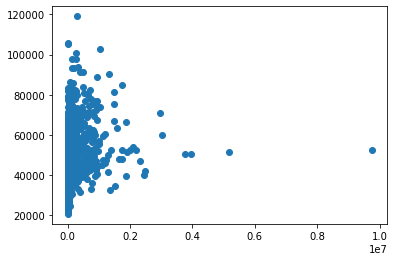

In [50]:
plt.scatter(df['Total Population 2010'], df['MHI 2010'])

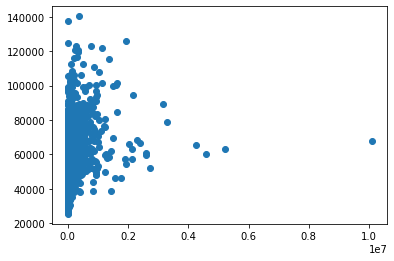

In [51]:
plt.scatter(df['Total Population 2018'], df['MHI 2018'])

Lets see what the min/max, stdev looks like without it those huge counties (E.g. LA). Then we can use those more descriptive stats and apply it to the original dataframe--in effect, dodging the outliers without removing its data

In [52]:
df[df['Total Population 2010'] > 5000000] #so LA County and Cook County seem to be those big population centres

,GEO_ID,County ID,County,State,Total Population 2010,Total Male Population 2010,Total Female Population 2010,Poverty Percent 2010,MHI 2010,County ID 2018,Total Population 2018,Total Male Population 2018,Total Female Population 2018,Poverty Percent 2018,MHI 2018,% Total Population Change,% Male Population Change,% Female Population Change,% Poverty Change,% MHI Change
267,0500000US06037,6037,Los Angeles County,California,9758256,4811964,4946292,17.6,52595.0,06037,10098052,4976788,5121264,14.2,67986.0,3.48,3.43,3.54,-3.4,29.26
673,0500000US17031,17031,Cook County,Illinois,5172848,2504399,2668449,16.8,51457.0,17031,5223719,2534640,2689079,13.8,63347.0,0.98,1.21,0.77,-3.0,23.11


In [53]:
df_Otl = df[(df.GEO_ID != '0500000US06037')] #Removing LA County
df_Otl = df_Otl[(df_Otl.GEO_ID != '0500000US17031')] #Removing Cook County
df_Otl

,GEO_ID,County ID,County,State,Total Population 2010,Total Male Population 2010,Total Female Population 2010,Poverty Percent 2010,MHI 2010,County ID 2018,Total Population 2018,Total Male Population 2018,Total Female Population 2018,Poverty Percent 2018,MHI 2018,% Total Population Change,% Male Population Change,% Female Population Change,% Poverty Change,% MHI Change
0,0500000US17083,17083,Jersey County,Illinois,22932,11221,11711,10.0,54278.0,17083,22069,10841,11228,8.9,59117.0,-3.76,-3.39,-4.12,-1.1,8.92
1,0500000US17085,17085,Jo Daviess County,Illinois,22728,11431,11297,9.3,45972.0,17085,21834,10956,10878,7.8,56832.0,-3.93,-4.16,-3.71,-1.5,23.62
2,0500000US17087,17087,Johnson County,Illinois,12710,7146,5564,14.2,41743.0,17087,12602,7015,5587,12.2,53884.0,-0.85,-1.83,0.41,-2.0,29.09
3,0500000US17089,17089,Kane County,Illinois,502628,251087,251541,11.0,65430.0,17089,530839,264211,266628,8.6,79834.0,5.61,5.23,6.00,-2.4,22.01
4,0500000US17091,17091,Kankakee County,Illinois,112100,55042,57058,14.8,45707.0,17091,111061,54615,56446,16.2,53884.0,-0.93,-0.78,-1.07,1.4,17.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,0500000US56037,56037,Sweetwater County,Wyoming,42266,21957,20309,9.1,67508.0,56037,44117,22882,21235,8.4,73315.0,4.38,4.21,4.56,-0.7,8.60
3138,0500000US56039,56039,Teton County,Wyoming,20802,10868,9934,9.0,68358.0,56039,23059,11911,11148,6.3,99087.0,10.85,9.60,12.22,-2.7,44.95
3139,0500000US56041,56041,Uinta County,Wyoming,20537,10422,10115,11.2,60532.0,56041,20609,10505,10104,10.0,63401.0,0.35,0.80,-0.11,-1.2,4.74
3140,0500000US56043,56043,Washakie County,Wyoming,8271,4259,4012,12.1,47831.0,56043,8129,4137,3992,11.9,55190.0,-1.72,-2.86,-0.50,-0.2,15.39


In [54]:
df.describe()

,County ID,Total Population 2010,Total Male Population 2010,Total Female Population 2010,Poverty Percent 2010,MHI 2010,Total Population 2018,Total Male Population 2018,Total Female Population 2018,Poverty Percent 2018,MHI 2018,% Total Population Change,% Male Population Change,% Female Population Change,% Poverty Change,% MHI Change
count,3142.000000,3.142000e+03,3.142000e+03,3.142000e+03,3141.000000,3141.000000,3.142000e+03,3.142000e+03,3.142000e+03,3141.000000,3141.000000,3142.000000,3142.000000,3142.000000,3141.000000,3141.000000
mean,30383.649268,9.674064e+04,4.754797e+04,4.919267e+04,16.761000,43147.248329,1.027699e+05,5.059968e+04,5.217022e+04,15.162655,52794.413244,1.550210,1.885207,1.306493,-1.598344,22.223079
std,15162.508374,3.085977e+05,1.513906e+05,1.572492e+05,6.243793,10743.174992,3.299077e+05,1.620390e+05,1.679069e+05,6.125703,13880.120635,8.846519,9.046238,9.917692,2.296170,8.333944
min,1001.000000,4.100000e+01,2.300000e+01,1.800000e+01,3.100000,20577.000000,7.500000e+01,3.800000e+01,3.700000e+01,2.600000,25385.000000,-51.330000,-49.430000,-53.720000,-18.500000,-4.840000
25%,18177.500000,1.109475e+04,5.552250e+03,5.529000e+03,12.300000,36135.000000,1.094800e+04,5.495750e+03,5.461250e+03,10.800000,43681.000000,-3.110000,-2.770000,-3.680000,-2.900000,17.030000
50%,29176.000000,2.569600e+04,1.279400e+04,1.288450e+04,15.900000,41263.000000,2.573600e+04,1.284900e+04,1.284850e+04,14.100000,50568.000000,0.040000,0.480000,-0.190000,-1.500000,21.780000
75%,45080.500000,6.607050e+04,3.266200e+04,3.321000e+04,20.200000,47724.000000,6.720900e+04,3.360025e+04,3.416750e+04,18.300000,58848.000000,4.697500,5.230000,4.617500,-0.300000,27.010000
max,56045.000000,9.758256e+06,4.811964e+06,4.946292e+06,50.100000,119075.000000,1.009805e+07,4.976788e+06,5.121264e+06,54.000000,140382.000000,148.780000,152.170000,225.260000,11.400000,79.250000


In [55]:
df_Otl.describe() #see the change in the population metrics?

,County ID,Total Population 2010,Total Male Population 2010,Total Female Population 2010,Poverty Percent 2010,MHI 2010,Total Population 2018,Total Male Population 2018,Total Female Population 2018,Poverty Percent 2018,MHI 2018,% Total Population Change,% Male Population Change,% Female Population Change,% Poverty Change,% MHI Change
count,3140.000000,3.140000e+03,3.140000e+03,3.140000e+03,3139.000000,3139.000000,3.140000e+03,3.140000e+03,3.140000e+03,3139.000000,3139.000000,3140.000000,3140.000000,3140.000000,3139.000000,3139.000000
mean,30395.655414,9.204713e+04,4.524820e+04,4.679893e+04,16.760720,43141.591271,9.795581e+04,4.823973e+04,4.971608e+04,15.163396,52786.211851,1.549777,1.884930,1.305952,-1.597324,22.220554
std,15159.233504,2.394272e+05,1.173627e+05,1.221142e+05,6.245765,10744.249022,2.621140e+05,1.287289e+05,1.334301e+05,6.127582,13880.613820,8.849264,9.049069,9.920767,2.296540,8.335637
min,1001.000000,4.100000e+01,2.300000e+01,1.800000e+01,3.100000,20577.000000,7.500000e+01,3.800000e+01,3.700000e+01,2.600000,25385.000000,-51.330000,-49.430000,-53.720000,-18.500000,-4.840000
25%,18180.500000,1.108775e+04,5.542000e+03,5.523250e+03,12.300000,36132.000000,1.093300e+04,5.492750e+03,5.458500e+03,10.800000,43680.000000,-3.112500,-2.770000,-3.682500,-2.800000,17.025000
50%,29178.000000,2.568800e+04,1.276950e+04,1.286900e+04,15.900000,41248.000000,2.573150e+04,1.282850e+04,1.284550e+04,14.100000,50565.000000,0.040000,0.480000,-0.200000,-1.500000,21.760000
75%,45081.500000,6.588000e+04,3.263875e+04,3.312600e+04,20.200000,47703.500000,6.705375e+04,3.355750e+04,3.408950e+04,18.300000,58827.500000,4.702500,5.230000,4.625000,-0.300000,27.000000
max,56045.000000,3.950999e+06,1.965768e+06,1.985231e+06,50.100000,119075.000000,4.602523e+06,2.288295e+06,2.314228e+06,54.000000,140382.000000,148.780000,152.170000,225.260000,11.400000,79.250000


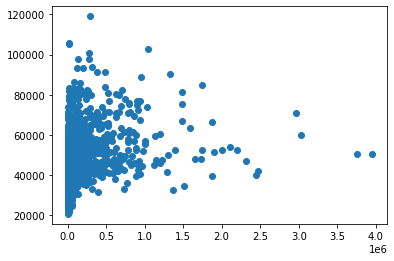

In [56]:
plt.scatter(df_Otl['Total Population 2010'], df_Otl['MHI 2010'])

Now, to quantile the upper, middle, and lower thirds for both population and mhi of this new outlier-less dataframe. We'll apply those parameters to the original df later

In [57]:
Pop_parameters_2010 = df_Otl['Total Population 2010'].quantile([0, 0.33, 0.66, 1])
Pop_parameters_2010

0.00         41.00
0.33      15024.80
0.66      44408.36
1.00    3950999.00
Name: Total Population 2010, dtype: float64

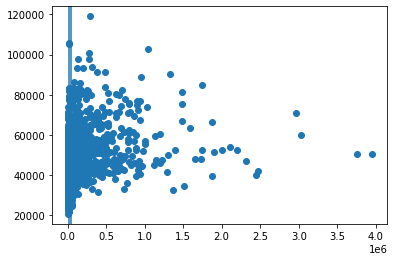

In [58]:
plt.scatter(df_Otl['Total Population 2010'], df_Otl['MHI 2010'])

plt.axvline(x=Pop_parameters_2010[.33])
plt.axvline(x=Pop_parameters_2010[.66])

So we can see that quantiles aren't super useful here because the data is so close. Lets see if a split across the range is clearer.

In [59]:
print('Minimum Population =', df_Otl['Total Population 2010'].min(), 'Maximum Population = ', df_Otl['Total Population 2010'].max())

Minimum Population = 41 Maximum Population =  3950999


In [60]:
pop10_third = (((df_Otl['Total Population 2010'].max()) - (df_Otl['Total Population 2010'].min()))/3)

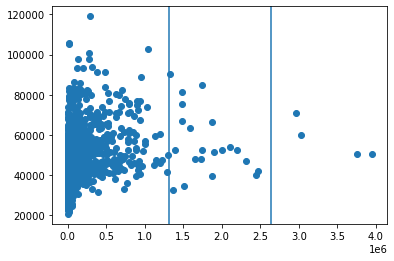

In [61]:
plt.scatter(df_Otl['Total Population 2010'], df_Otl['MHI 2010'])

plt.axvline(x= pop10_third)
plt.axvline(x= 2*pop10_third)

This seems to work out a bit better. Lets try the MHI too

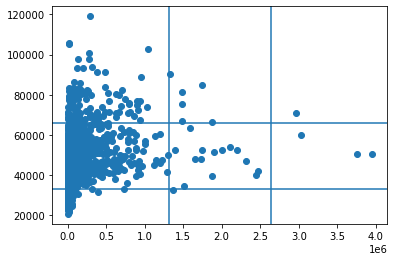

In [62]:
pop10_third = (((df_Otl['Total Population 2010'].max()) - (df_Otl['Total Population 2010'].min()))/3)
MHI10_third = (((df_Otl['MHI 2010'].max()) - (df_Otl['MHI 2010'].min()))/3)

plt.scatter(df_Otl['Total Population 2010'], df_Otl['MHI 2010'])

plt.axvline(x= pop10_third)
plt.axvline(x= 2*pop10_third)

plt.axhline(y= MHI10_third)
plt.axhline(y= 2*MHI10_third)

OK, so we have pop10_third and MHI10_third as decent markers for 2010 to apply to our full data later on. Lets quickly make the 2018 versions

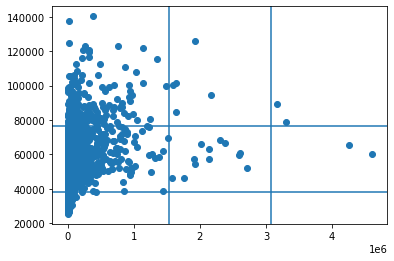

In [63]:
pop18_third = (((df_Otl['Total Population 2018'].max()) - (df_Otl['Total Population 2018'].min()))/3)
MHI18_third = (((df_Otl['MHI 2018'].max()) - (df_Otl['MHI 2018'].min()))/3)

plt.scatter(df_Otl['Total Population 2018'], df_Otl['MHI 2018'])

plt.axvline(x= pop18_third)
plt.axvline(x= 2*pop18_third)

plt.axhline(y= MHI18_third)
plt.axhline(y= 2*MHI18_third)

Iiiiiiii don't quite know what to do with the Change data yet. Its so generic (see graph) that I'm not convinced I can easily do this third-split with that data too. Lets hold on that for now.

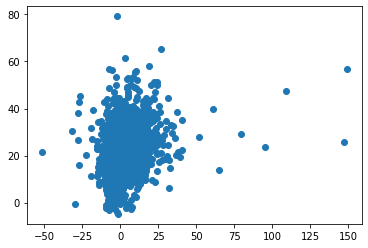

In [64]:
plt.scatter(df['% Total Population Change'], df['% MHI Change'])

In [65]:
#adding in categorical variables to a new column based off of our outlier-less third ranges
def f(row):
    if row['Total Population 2010'] < pop10_third:
        val = 0
    elif row['Total Population 2010'] > 2*pop10_third:
        val = 2
    else:
        val = 1
    return val

df['2010 Population Split'] = df.apply(f, axis = 1)

In [66]:
df['2010 Population Split'].value_counts()

0    3115
1      21
2       6
Name: 2010 Population Split, dtype: int64

In [67]:
def f(row):
    if row['MHI 2010'] < MHI10_third:
        val = 0
    elif row['MHI 2010'] > 2*MHI10_third:
        val = 2
    else:
        val = 1
    return val

df['2010 MHI Split'] = df.apply(f, axis = 1)

In [68]:
df['2010 MHI Split'].value_counts()

1    2617
0     389
2     136
Name: 2010 MHI Split, dtype: int64

In [69]:
def f(row):
    if row['2010 Population Split'] == 0 and row['2010 MHI Split'] == 0: #small, poor
        val = 0
    elif row['2010 Population Split'] == 1 and row['2010 MHI Split'] == 0: #medium, poor
        val = 1
    elif row['2010 Population Split'] == 2 and row['2010 MHI Split'] == 0: #large, poor
        val = 2
    elif row['2010 Population Split'] == 0 and row['2010 MHI Split'] == 1: #small, medium
        val = 3
    elif row['2010 Population Split'] == 1 and row['2010 MHI Split'] == 1: #medium, medium
        val = 4
    elif row['2010 Population Split'] == 2 and row['2010 MHI Split'] == 1: #large, medium
        val = 5
    elif row['2010 Population Split'] == 0 and row['2010 MHI Split'] == 2: #small, rich
        val = 6
    elif row['2010 Population Split'] == 1 and row['2010 MHI Split'] == 2: #medium, rich
        val = 7
    elif row['2010 Population Split'] == 2 and row['2010 MHI Split'] == 2: #large, rich
        val = 8
    else:
        val = 100
    return val
df['2010 Split'] = df.apply(f, axis = 1)

In [70]:
df['2010 Split'].value_counts()

3    2598
0     388
6     129
4      14
7       6
5       5
1       1
8       1
Name: 2010 Split, dtype: int64

In [71]:
def f(row):
    if row['Total Population 2018'] < pop18_third:
        val = 0
    elif row['Total Population 2018'] > 2*pop18_third:
        val = 2
    else:
        val = 1
    return val

df['2018 Population Split'] = df.apply(f, axis = 1)

In [72]:
df['2018 Population Split'].value_counts()

0    3119
1      17
2       6
Name: 2018 Population Split, dtype: int64

In [73]:
def f(row):
    if row['MHI 2018'] < MHI18_third:
        val = 0
    elif row['MHI 2018'] > 2*MHI18_third:
        val = 2
    else:
        val = 1
    return val

df['2018 MHI Split'] = df.apply(f, axis = 1)

In [74]:
df['2018 MHI Split'].value_counts()

1    2622
0     334
2     186
Name: 2018 MHI Split, dtype: int64

In [75]:
def f(row):
    if row['2018 Population Split'] == 0 and row['2018 MHI Split'] == 0: #small, poor
        val = 0
    elif row['2018 Population Split'] == 1 and row['2018 MHI Split'] == 0: #medium, poor
        val = 1
    elif row['2018 Population Split'] == 2 and row['2018 MHI Split'] == 0: #large, poor
        val = 2
    elif row['2018 Population Split'] == 0 and row['2018 MHI Split'] == 1: #small, medium
        val = 3
    elif row['2018 Population Split'] == 1 and row['2018 MHI Split'] == 1: #medium, medium
        val = 4
    elif row['2018 Population Split'] == 2 and row['2018 MHI Split'] == 1: #large, medium
        val = 5
    elif row['2018 Population Split'] == 0 and row['2018 MHI Split'] == 2: #small, rich
        val = 6
    elif row['2018 Population Split'] == 1 and row['2018 MHI Split'] == 2: #medium, rich
        val = 7
    elif row['2018 Population Split'] == 2 and row['2018 MHI Split'] == 2: #large, rich
        val = 8
    else:
        val = 100
    return val
df['2018 Split'] = df.apply(f, axis = 1)

In [76]:
df['2018 Split'].value_counts()

3    2606
0     334
6     179
4      12
7       5
5       4
8       2
Name: 2018 Split, dtype: int64

### DBSCAN Analyses

**2010 Clustering Snapshot**

In [77]:
#Grabbing the features we want for the 2010 snapshot
X = df[Features_2010]

#taking out any NaNs, and standardizing the data.
X = np.nan_to_num(X)
X = preprocessing.StandardScaler().fit(X).transform(X)

In [78]:
X

array([[-0.2392124 ,  1.03503087],
       [-0.23987356,  0.26362088],
       [-0.27234171, -0.12914253],
       ...,
       [-0.24697455,  1.61586378],
       [-0.28672842,  0.43627332],
       [-0.2906338 ,  0.5126156 ]])

In [79]:
#finding reasonable DBSCAN input values
neigh = NearestNeighbors(n_neighbors = 2)

nbrs = neigh.fit(X)

distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis = 0)

distances = distances[:, 1]

(0.0, 1.0)

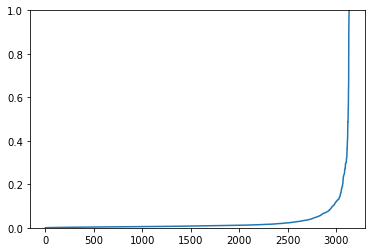

In [80]:
plt.plot(distances) #our optimal value of epsilon is the point of maximum curvature
plt.ylim((0,1)) #looks like epsilon should be about 0.2

In [81]:
from sklearn.cluster import DBSCAN
import sklearn.utils

sklearn.utils.check_random_state(1000)

#Compute DBSCAN
db = DBSCAN(eps = .1, min_samples = 4).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype = bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [82]:
from scipy import stats
stats.describe(db.labels_)

DescribeResult(nobs=3142, minmax=(-1, 12), mean=0.034691279439847234, variance=1.0554659823435395, skewness=7.9456232736676204, kurtosis=73.3525945162364)

(array([3081.,    4.,    7.,   11.,    5.,    6.,   11.,    4.,    4.,
           9.]),
 array([-1. ,  0.3,  1.6,  2.9,  4.2,  5.5,  6.8,  8.1,  9.4, 10.7, 12. ]),
 <a list of 10 Patch objects>)

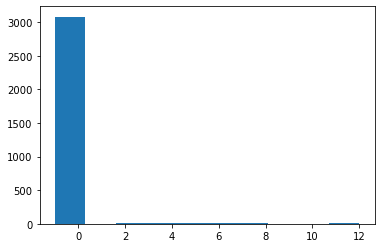

In [83]:
plt.hist(db.labels_)

In [84]:
#insert the 2010 snapshot into the main df
df.insert(0, 'DBSCAN 2010 Cluster', db.labels_)

**2018 Snapshot Clustering**

In [85]:
#Grabbing the features we want for the 2018 snapshot
X = df[Features_2018]

#taking out any NaNs, and standardizing the data.
X = np.nan_to_num(X)
X = preprocessing.StandardScaler().fit(X).transform(X)

In [86]:
X

array([[-0.24465553,  0.45582127],
       [-0.24536796,  0.29152286],
       [-0.273356  ,  0.07955275],
       ...,
       [-0.24908171,  0.76385382],
       [-0.28691649,  0.1734581 ],
       [-0.29003605,  0.11083057]])

In [87]:
#finding reasonable DBSCAN input values
neigh = NearestNeighbors(n_neighbors = 2)

nbrs = neigh.fit(X)

distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis = 0)

distances = distances[:, 1]

(0.0, 1.0)

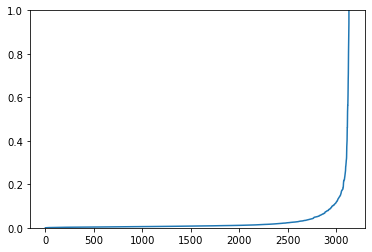

In [88]:
plt.plot(distances) #our optimal value of epsilon is the point of maximum curvature
plt.ylim((0,1)) #looks like epsilon should be about 0.2

In [89]:
from sklearn.cluster import DBSCAN
import sklearn.utils

sklearn.utils.check_random_state(1000)

#Compute DBSCAN
db = DBSCAN(eps = 0.2, min_samples = 5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype = bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))

In [90]:
#insert the 2018 snapshot into the main df
df.insert(0, 'DBSCAN 2018 Cluster', db.labels_)

**% Change Clustering**

In [91]:
#Grabbing the features we want for the 2010 snapshot
X = df[Features_delta]

#taking out any NaNs, and standardizing the data.
X = np.nan_to_num(X)
X = preprocessing.StandardScaler().fit(X).transform(X)

In [92]:
X

array([[-0.60035537, -1.59410845],
       [-0.61957503,  0.16833019],
       [-0.27136007,  0.82414919],
       ...,
       [-0.13569191, -2.09526447],
       [-0.36971949, -0.81839566],
       [-0.12099453, -1.26679842]])

In [93]:
#finding reasonable DBSCAN input values
neigh = NearestNeighbors(n_neighbors = 2)

nbrs = neigh.fit(X)

distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis = 0)

distances = distances[:, 1]

(0.0, 1.0)

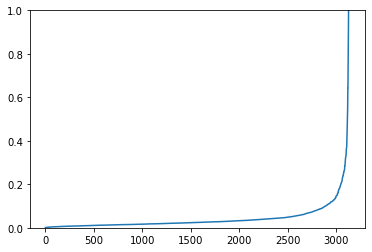

In [94]:
plt.plot(distances) #our optimal value of epsilon is the point of maximum curvature
plt.ylim((0,1)) #looks like epsilon should be about 0.25

In [95]:
from sklearn.cluster import DBSCAN
import sklearn.utils

sklearn.utils.check_random_state(1000)

#Compute DBSCAN
db = DBSCAN(eps = 0.3, min_samples = 5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype = bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))

In [96]:
#insert the change clustering into the main df
df.insert(0, 'DBSCAN Change Cluster', db.labels_)

In [97]:
df['DBSCAN Change Cluster'].value_counts()

 0    3029
-1     100
 1       9
 2       4
Name: DBSCAN Change Cluster, dtype: int64

In [98]:
df['DBSCAN 2018 Cluster'].value_counts()

 0    2957
-1     142
 3      14
 4       7
 2       7
 5       5
 1       5
 6       5
Name: DBSCAN 2018 Cluster, dtype: int64

In [99]:
df['DBSCAN 2010 Cluster'].value_counts()

 0     2809
-1      272
 4        8
 2        7
 7        6
 6        6
 11       5
 5        5
 8        5
 9        4
 1        4
 12       4
 10       4
 3        3
Name: DBSCAN 2010 Cluster, dtype: int64

In [100]:
df.head() #nice, all of our clusters are showing up in the dataframe

,DBSCAN Change Cluster,DBSCAN 2018 Cluster,DBSCAN 2010 Cluster,GEO_ID,County ID,County,State,Total Population 2010,Total Male Population 2010,Total Female Population 2010,...,% Male Population Change,% Female Population Change,% Poverty Change,% MHI Change,2010 Population Split,2010 MHI Split,2010 Split,2018 Population Split,2018 MHI Split,2018 Split
0,0,0,0,0500000US17083,17083,Jersey County,Illinois,22932,11221,11711,...,-3.39,-4.12,-1.1,8.92,0,1,3,0,1,3
1,0,0,0,0500000US17085,17085,Jo Daviess County,Illinois,22728,11431,11297,...,-4.16,-3.71,-1.5,23.62,0,1,3,0,1,3
2,0,0,0,0500000US17087,17087,Johnson County,Illinois,12710,7146,5564,...,-1.83,0.41,-2.0,29.09,0,1,3,0,1,3
3,0,1,-1,0500000US17089,17089,Kane County,Illinois,502628,251087,251541,...,5.23,6.00,-2.4,22.01,0,1,3,0,2,6
4,0,0,0,0500000US17091,17091,Kankakee County,Illinois,112100,55042,57058,...,-0.78,-1.07,1.4,17.89,0,1,3,0,1,3


### KMeans Analyses

2010 Snapshot

In [101]:
#Grabbing the features we want for the 2010 snapshot
X = df[Features_2010]

#taking out any NaNs, and standardizing the data.
X = np.nan_to_num(X)
X = preprocessing.StandardScaler().fit(X).transform(X)

#running iterative KMeans the analyses
for clusters in range (1, 12):
    kmeans = KMeans(n_clusters = clusters, random_state = 0).fit(X)
    unique, counts = np.unique(kmeans.labels_, return_counts = True)
    print(dict(zip(unique, counts)))

{0: 3142}
{0: 482, 1: 2660}
{0: 736, 1: 2380, 2: 26}
{0: 1240, 1: 18, 2: 1652, 3: 232}
{0: 1635, 1: 1244, 2: 33, 3: 2, 4: 228}
{0: 1613, 1: 1201, 2: 1, 3: 17, 4: 202, 5: 108}
{0: 1233, 1: 1, 2: 138, 3: 556, 4: 18, 5: 1100, 6: 96}
{0: 1099, 1: 550, 2: 5, 3: 1216, 4: 104, 5: 140, 6: 1, 7: 27}
{0: 784, 1: 240, 2: 25, 3: 734, 4: 1, 5: 107, 6: 1152, 7: 5, 8: 94}
{0: 779, 1: 246, 2: 22, 3: 734, 4: 1, 5: 41, 6: 1157, 7: 5, 8: 55, 9: 102}
{0: 100, 1: 526, 2: 162, 3: 5, 4: 846, 5: 21, 6: 1, 7: 481, 8: 46, 9: 38, 10: 916}


In [102]:
KMeans(n_clusters = 9, random_state = 0).fit(X)

KMeans(n_clusters=9, random_state=0)

In [103]:
#insert the 2010 clustering into the main df
df.insert(0, 'Kmeans 2010 Cluster', kmeans.labels_)

2018 Snapshot

In [104]:
#Grabbing the features we want for the 2010 snapshot
X = df[Features_2018]

#taking out any NaNs, and standardizing the data.
X = np.nan_to_num(X)
X = preprocessing.StandardScaler().fit(X).transform(X)

#running iterative KMeans the analyses
for clusters in range (1, 12):
    kmeans = KMeans(n_clusters = clusters, random_state = 0).fit(X)
    unique, counts = np.unique(kmeans.labels_, return_counts = True)
    print(dict(zip(unique, counts)))

{0: 3142}
{0: 2729, 1: 413}
{0: 2511, 1: 612, 2: 19}
{0: 1580, 1: 248, 2: 1296, 3: 18}
{0: 1322, 1: 1507, 2: 55, 3: 254, 4: 4}
{0: 1463, 1: 235, 2: 1321, 3: 17, 4: 105, 5: 1}
{0: 1311, 1: 142, 2: 17, 3: 952, 4: 98, 5: 621, 6: 1}
{0: 1000, 1: 1290, 2: 99, 3: 5, 4: 23, 5: 143, 6: 1, 7: 581}
{0: 1182, 1: 777, 2: 97, 3: 5, 4: 22, 5: 74, 6: 1, 7: 224, 8: 760}
{0: 817, 1: 211, 2: 1196, 3: 3, 4: 92, 5: 15, 6: 1, 7: 727, 8: 35, 9: 45}
{0: 833, 1: 35, 2: 1, 3: 173, 4: 558, 5: 5, 6: 473, 7: 92, 8: 43, 9: 17, 10: 912}


In [105]:
KMeans(n_clusters = 9, random_state = 0).fit(X)

KMeans(n_clusters=9, random_state=0)

In [106]:
#insert the 2018 clustering into the main df
df.insert(0, 'Kmeans 2018 Cluster', kmeans.labels_)

Change Clusters

In [107]:
#Grabbing the features we want for the 2010 snapshot
X = df[Features_delta]

#taking out any NaNs, and standardizing the data.
X = np.nan_to_num(X)
X = preprocessing.StandardScaler().fit(X).transform(X)

#running iterative KMeans the analyses
for clusters in range (1, 12):
    kmeans = KMeans(n_clusters = clusters, random_state = 0).fit(X)
    unique, counts = np.unique(kmeans.labels_, return_counts = True)
    print(dict(zip(unique, counts)))

{0: 3142}
{0: 2037, 1: 1105}
{0: 379, 1: 1259, 2: 1504}
{0: 1240, 1: 1387, 2: 508, 3: 7}
{0: 1339, 1: 490, 2: 404, 3: 7, 4: 902}
{0: 668, 1: 567, 2: 585, 3: 165, 4: 5, 5: 1152}
{0: 706, 1: 197, 2: 494, 3: 1027, 4: 590, 5: 123, 6: 5}
{0: 387, 1: 540, 2: 419, 3: 5, 4: 1030, 5: 487, 6: 159, 7: 115}
{0: 401, 1: 846, 2: 256, 3: 5, 4: 392, 5: 390, 6: 101, 7: 100, 8: 651}
{0: 330, 1: 596, 2: 63, 3: 72, 4: 755, 5: 406, 6: 5, 7: 357, 8: 298, 9: 260}
{0: 430, 1: 329, 2: 338, 3: 5, 4: 652, 5: 202, 6: 590, 7: 274, 8: 57, 9: 46, 10: 219}


In [108]:
KMeans(n_clusters = 9, random_state = 0).fit(X)

KMeans(n_clusters=9, random_state=0)

In [109]:
#insert the 2010 clustering into the main df
df.insert(0, 'Kmeans Change Cluster', kmeans.labels_)

In [110]:
df.describe() #nothing looks too crazy, which is good. We have 16 groups in Change and 2018 clusters, 21 for 2010 clusters

,Kmeans Change Cluster,Kmeans 2018 Cluster,Kmeans 2010 Cluster,DBSCAN Change Cluster,DBSCAN 2018 Cluster,DBSCAN 2010 Cluster,County ID,Total Population 2010,Total Male Population 2010,Total Female Population 2010,...,% Male Population Change,% Female Population Change,% Poverty Change,% MHI Change,2010 Population Split,2010 MHI Split,2010 Split,2018 Population Split,2018 MHI Split,2018 Split
count,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3.142000e+03,3.142000e+03,3.142000e+03,...,3142.000000,3142.000000,3141.000000,3141.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000
mean,4.187142,5.064290,5.600573,-0.026416,0.000637,0.034691,30383.649268,9.674064e+04,4.754797e+04,4.919267e+04,...,1.885207,1.306493,-1.598344,22.223079,0.010503,0.919478,2.768937,0.009230,0.952896,2.867919
std,2.880511,3.865414,3.476108,0.197733,0.478110,1.027359,15162.508374,3.085977e+05,1.513906e+05,1.572492e+05,...,9.046238,9.917692,2.296170,8.333944,0.119232,0.400822,1.215972,0.113877,0.404145,1.225873
min,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,1001.000000,4.100000e+01,2.300000e+01,1.800000e+01,...,-49.430000,-53.720000,-18.500000,-4.840000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,18177.500000,1.109475e+04,5.552250e+03,5.529000e+03,...,-2.770000,-3.680000,-2.900000,17.030000,0.000000,1.000000,3.000000,0.000000,1.000000,3.000000
50%,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,29176.000000,2.569600e+04,1.279400e+04,1.288450e+04,...,0.480000,-0.190000,-1.500000,21.780000,0.000000,1.000000,3.000000,0.000000,1.000000,3.000000
75%,6.000000,10.000000,10.000000,0.000000,0.000000,0.000000,45080.500000,6.607050e+04,3.266200e+04,3.321000e+04,...,5.230000,4.617500,-0.300000,27.010000,0.000000,1.000000,3.000000,0.000000,1.000000,3.000000
max,10.000000,10.000000,10.000000,2.000000,6.000000,12.000000,56045.000000,9.758256e+06,4.811964e+06,4.946292e+06,...,152.170000,225.260000,11.400000,79.250000,2.000000,2.000000,8.000000,2.000000,2.000000,8.000000


## Visualization

Showing the clusters--what characterizes each? What counties are in each?

**2010**

In [111]:
df[['DBSCAN 2010 Cluster', 'Total Population 2010', 'Poverty Percent 2010', 'MHI 2010']].groupby(['DBSCAN 2010 Cluster']).mean()

,Total Population 2010,Poverty Percent 2010,MHI 2010
DBSCAN 2010 Cluster,,,
-1,669914.011029,13.067528,59897.501845
0,39838.143111,17.251299,41111.479174
1,299014.500000,7.300000,69330.750000
2,34512.428571,7.957143,69573.857143
3,85954.666667,8.466667,68720.000000
4,19795.875000,8.787500,68096.125000
5,185709.000000,8.460000,65725.400000
6,45663.833333,6.816667,76456.500000
7,317904.666667,16.733333,44330.333333


In [112]:
df[['Kmeans 2010 Cluster', 'Total Population 2010', 'Poverty Percent 2010', 'MHI 2010']].groupby(['Kmeans 2010 Cluster']).mean()

,Total Population 2010,Poverty Percent 2010,MHI 2010
Kmeans 2010 Cluster,,,
0,6.007292e+05,16.243000,48554.380000
1,1.996019e+04,25.795429,30882.024762
2,1.273936e+05,8.813580,64160.808642
3,3.772650e+06,15.820000,56560.800000
4,5.068212e+04,14.552719,43683.622931
5,1.745870e+06,17.776190,48948.000000
6,9.758256e+06,17.600000,52595.000000
7,6.745909e+04,11.561538,51513.644491
8,1.589107e+05,6.186957,84732.652174


**2018**

In [113]:
df[['DBSCAN 2018 Cluster', 'Total Population 2018', 'Poverty Percent 2018', 'MHI 2018']].groupby(['DBSCAN 2018 Cluster']).mean()

,Total Population 2018,Poverty Percent 2018,MHI 2018
DBSCAN 2018 Cluster,,,
-1,1.053521e+06,10.788652,80262.085106
0,5.111804e+04,15.427731,51224.044640
1,5.227536e+05,9.460000,79778.000000
2,5.228473e+05,13.000000,59915.857143
3,5.085875e+05,10.492857,69249.428571
4,9.049529e+04,5.328571,103314.285714
5,6.695776e+05,14.280000,55831.400000
6,9.543484e+05,18.200000,50129.600000


In [114]:
df[['Kmeans 2018 Cluster', 'Total Population 2018', 'Poverty Percent 2018', 'MHI 2018']].groupby(['Kmeans 2018 Cluster']).mean()

,Total Population 2018,Poverty Percent 2018,MHI 2018
Kmeans 2018 Cluster,,,
0,5.196888e+04,12.767947,53809.990396
1,1.020982e+06,8.171429,93131.828571
2,1.009805e+07,14.200000,67986.000000
3,1.608802e+05,7.790751,79767.421965
4,2.226850e+04,24.124776,36865.967684
5,4.109434e+06,12.920000,71394.400000
6,7.047650e+04,10.008457,63556.251586
7,6.817545e+05,13.594565,61007.336957
8,1.915122e+05,5.362791,106050.046512


**Change**

In [115]:
df[['DBSCAN Change Cluster', '% Total Population Change', '% Poverty Change', '% MHI Change']].groupby(['DBSCAN Change Cluster']).mean()

,% Total Population Change,% Poverty Change,% MHI Change
DBSCAN Change Cluster,,,
-1,17.045700,-2.707000,33.254500
0,1.018670,-1.559676,21.811371
1,5.872222,-3.933333,48.550000
2,6.947500,2.100000,-1.135000


In [116]:
df[['Kmeans Change Cluster', '% Total Population Change', '% Poverty Change', '% MHI Change']].groupby(['Kmeans Change Cluster']).mean()

,% Total Population Change,% Poverty Change,% MHI Change
Kmeans Change Cluster,,,
0,5.124233,-2.207209,25.433535
1,-6.788663,-0.970517,17.280669
2,-1.927722,-2.670414,32.709822
3,115.822000,-2.580000,36.554000
4,-2.403328,-1.660583,23.762899
5,11.645743,-3.251980,32.582475
6,0.819932,-1.100678,17.180898
7,-2.706934,0.542857,8.038132
8,29.095263,-2.303509,26.966842


## Maps

In [117]:
!pip install folium
import folium
import os
import json

     |████████████████████████████████| 93 kB 4.1 MB/s  eta 0:00:01


In [118]:
#creating a basic map of the USA

latitude = 37
longitude = -95

USA_map = folium.Map(location=[latitude, longitude], zoom_start = 4)
USA_map

In [119]:
#download geojson file of all counties in USA. From my github--i converted that file from the

!wget --quiet https://github.com/hajnoszian/ForFutureReference/raw/master/cb_2018_us_county_5m.geojson

In [ ]:
!pip install geopandas

     |████████████████████████████████| 962 kB 13.2 MB/s eta 0:00:01
     |████████████████████████████████| 6.4 MB 54.6 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 61.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 62.9 MB/s eta 0:00:01


In [ ]:
import geopandas as gpd
county_geo = 'cb_2018_us_county_5m.geojson'
geoPdata = gpd.read_file(county_geo)

In [ ]:
dfGEO = pd.merge(
    left = geoPdata,
    right = df,
    left_on = 'AFFGEOID', right_on = 'GEO_ID')
dfGEO.head()

In [ ]:
dfGEO.to_file('full_county_data.geojson', driver = 'GeoJSON')

In [ ]:
county_geo = 'full_county_data.geojson'

#to check the key on variables
#with open(county_geo) as f:
#    data = json.load(f)
#data 

This first one is a test to see if the counties map on correctly

In [ ]:
latitude = 37
longitude = -95

USA_map = folium.Map(location=[latitude, longitude], zoom_start = 4)
USA_map

#plotting the boundaries
folium.Choropleth(
    geo_data = county_geo,
    data = df,
    columns = ['GEO_ID', 'Total Population 2010'],
    key_on = 'feature.properties.AFFGEOID',
    fill_color = 'YlOrRd',
    fill_opacity = 0.6,
    line_opacity= .4,
    legend_name = "2010 Total Population"
).add_to(USA_map)
USA_map
#now to add descriptives

### Maps of 2010

> Population \
> MHI \
> Clustering \
> Split

**Population 2010**

In [ ]:
latitude = 37
longitude = -95

USA_map = folium.Map(location=[latitude, longitude], zoom_start = 4)

bins = list(df['Total Population 2010'].quantile([0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 1])) #this is to break up the legend into more discernible color groupings


#plotting the boundaries
folium.Choropleth(
    geo_data = county_geo,
    data = df,
    columns = ['GEO_ID', 'Total Population 2010'],
    key_on = 'feature.properties.AFFGEOID',
    fill_color = 'Blues',
    fill_opacity = 0.6,
    line_opacity= .4,
    legend_name = "2010 Total Population",
    bins = bins,
).add_to(USA_map)
USA_map


**MHI 2010**

In [ ]:
latitude = 37
longitude = -95

USA_map = folium.Map(location=[latitude, longitude], zoom_start = 4)
USA_map

bins = list(df['MHI 2010'].quantile([0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 1])) #this is to break up the legend into more discernible color groupings

#plotting the boundaries
folium.Choropleth(
    geo_data = county_geo,
    data = df,
    columns = ['GEO_ID', 'MHI 2010'],
    key_on = 'feature.properties.AFFGEOID',
    fill_color = 'BuGn',
    fill_opacity = 0.6,
    line_opacity= .4,
    legend_name = "MHI 2010",
    bins = bins
).add_to(USA_map)
USA_map

In [ ]:
df.head()

**Clusters 2010**

In [ ]:
latitude = 37
longitude = -95

USA_map = folium.Map(location=[latitude, longitude], zoom_start = 4)
USA_map

#plotting the boundaries
choropleth = folium.Choropleth(
    geo_data = county_geo,
    data = df,
    columns = ['GEO_ID', 'Kmeans 2010 Cluster'],
    key_on = 'feature.properties.AFFGEOID',
    fill_color = 'Set1',
    fill_opacity = 0.6,
    line_opacity= .4,
    highlight = True,
    legend_name = "Kmeans Clusters"
).add_to(USA_map)

#adding labels
style_function = "font-size: 15px; font-weight: bold"
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(fields = ['County', 'Kmeans 2010 Cluster', 'Total Population 2010', 'MHI 2010'],
                                   aliases = ['County Name', 'Cluster', 'Population', 'MHI'],
                                   labels = True))

USA_map

In [ ]:
latitude = 37
longitude = -95

USA_map = folium.Map(location=[latitude, longitude], zoom_start = 4)
USA_map

#plotting the boundaries
choropleth = folium.Choropleth(
    geo_data = county_geo,
    data = df,
    columns = ['GEO_ID', 'DBSCAN 2010 Cluster'],
    key_on = 'feature.properties.AFFGEOID',
    fill_color = 'Set1',
    fill_opacity = 0.6,
    line_opacity= .4,
    highlight = True,
    legend_name = "DBSCAN Clusters"
).add_to(USA_map)

#adding labels
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(fields = ['County', 'DBSCAN 2010 Cluster', 'Total Population 2010', 'MHI 2010'],
                                   aliases = ['County Name', 'Cluster', 'Population', 'MHI'],
                                   labels = True))

USA_map

### Maps of 2018

> Population \
> MHI \
> Clustering \
> Split

**Population 2018**

In [ ]:
latitude = 37
longitude = -95

USA_map = folium.Map(location=[latitude, longitude], zoom_start = 4)
USA_map

bins = list(df['Total Population 2018'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])) #this is to break up the legend into more discernible color groupings

#plotting the boundaries
folium.Choropleth(
    geo_data = county_geo,
    data = df,
    columns = ['GEO_ID', 'Total Population 2018'],
    key_on = 'feature.properties.AFFGEOID',
    fill_color = 'PuBu',
    fill_opacity = 0.6,
    line_opacity= .4,
    legend_name = "2018 Total Population",
    bins = bins
).add_to(USA_map)
USA_map

**MHI 2018**

In [ ]:
latitude = 37
longitude = -95

USA_map = folium.Map(location=[latitude, longitude], zoom_start = 4)
USA_map

bins = list(df['MHI 2018'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])) #this is to break up the legend into more discernible color groupings

#plotting the boundaries
folium.Choropleth(
    geo_data = county_geo,
    data = df,
    columns = ['GEO_ID', 'MHI 2018'],
    key_on = 'feature.properties.AFFGEOID',
    fill_color = 'BuGn',
    fill_opacity = 0.6,
    line_opacity= .4,
    legend_name = "MHI 2018",
    bins = bins
).add_to(USA_map)
USA_map

**Clusters 2018**

In [ ]:
latitude = 37
longitude = -95

USA_map = folium.Map(location=[latitude, longitude], zoom_start = 4)
USA_map

#plotting the boundaries
choropleth = folium.Choropleth(
    geo_data = county_geo,
    data = df,
    columns = ['GEO_ID', 'Kmeans 2018 Cluster'],
    key_on = 'feature.properties.AFFGEOID',
    fill_color = 'Set1',
    fill_opacity = 0.6,
    line_opacity= .4,
    highlight = True,
    legend_name = "Kmeans Clusters"
).add_to(USA_map)

#adding labels

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(fields = ['County', 'Kmeans 2018 Cluster', 'Total Population 2018', 'MHI 2018'],
                                   aliases = ['County Name', 'Cluster', 'Population', 'MHI'],
                                   labels = True))

USA_map

In [ ]:
latitude = 37
longitude = -95

USA_map = folium.Map(location=[latitude, longitude], zoom_start = 4)
USA_map

#plotting the boundaries
choropleth = folium.Choropleth(
    geo_data = county_geo,
    data = df,
    columns = ['GEO_ID', 'DBSCAN 2018 Cluster'],
    key_on = 'feature.properties.AFFGEOID',
    fill_color = 'Set1',
    fill_opacity = 0.6,
    line_opacity= .4,
    highlight = True,
    legend_name = "DBSCAN Clusters"
).add_to(USA_map)

#adding labels
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(fields = ['County', 'DBSCAN 2018 Cluster', 'Total Population 2018', 'MHI 2018'],
                                   aliases = ['County Name', 'Cluster', 'Population', 'MHI'],
                                   labels = True))

USA_map

### Change from 2010 to 2018

In [ ]:
df.head()

**Population Change**

In [ ]:
latitude = 37
longitude = -95

USA_map = folium.Map(location=[latitude, longitude], zoom_start = 4)
USA_map

bins = list(df['% Total Population Change'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])) #this is to break up the legend into more discernible color groupings


#plotting the boundaries
choropleth = folium.Choropleth(
    geo_data = county_geo,
    data = df,
    columns = ['GEO_ID', '% Total Population Change'],
    key_on = 'feature.properties.AFFGEOID',
    fill_color = 'RdBu',
    fill_opacity = 0.6,
    line_opacity= .4,
    highlight = True,
    legend_name = "DBSCAN Clusters"
).add_to(USA_map)

#adding labels
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(fields = ['County', 'Total Population 2010', 'Total Population 2018','% Total Population Change'],
                                   aliases = ['County Name', '2010 Population', '2018 Population', 'Change'],
                                   labels = True))

USA_map

**MHI Change**

In [ ]:

latitude = 37
longitude = -95

USA_map = folium.Map(location=[latitude, longitude], zoom_start = 4)
USA_map

bins = list(df['% MHI Change'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])) #this is to break up the legend into more discernible color groupings

#plotting the boundaries
folium.Choropleth(
    geo_data = county_geo,
    data = df,
    columns = ['GEO_ID', '% MHI Change'],
    key_on = 'feature.properties.AFFGEOID',
    fill_color = 'RdBu',
    fill_opacity = 0.6,
    line_opacity= .4,
    legend_name = "% MHI Change",
    bins = bins
).add_to(USA_map)

#adding labels
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(fields = ['County', 'MHI 2010', 'MHI 2018', '% MHI Change'],
                                   aliases = ['County Name', 'MHI 2010', 'MHI 2018', 'Change'],
                                   labels = True))

USA_map

**Poverty Change**

In [ ]:
latitude = 37
longitude = -95

USA_map = folium.Map(location=[latitude, longitude], zoom_start = 4)
USA_map

bins = list(df['% Poverty Change'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])) #this is to break up the legend into more discernible color groupings

#plotting the boundaries
folium.Choropleth(
    geo_data = county_geo,
    data = df,
    columns = ['GEO_ID', '% Poverty Change'],
    key_on = 'feature.properties.AFFGEOID',
    fill_color = 'RdBu',
    fill_opacity = 0.6,
    line_opacity= .4,
    legend_name = "% Poverty Change",
    bins = bins
).add_to(USA_map)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(fields = ['County', 'MHI 2010', 'MHI 2018', '% Poverty Change'],
                                   aliases = ['County Name', 'MHI 2010', 'MHI 2018', 'Change'],
                                   labels = True))
USA_map